In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops

import cv2
import matplotlib.pyplot as plt

from pathlib import Path
import os

from Libraries.get_absolute_path import get_absolute_path

# Partie 1 : Enregistrement local des images masquées

In [6]:
# Fonction pour enregistrer une image
def save_img(img : cv2.imread, file_name : str, path : str):
    path = get_absolute_path(path)
    try :
        initial_dir = Path(__file__).resolve().parent # __file__ is accessible in .py files but not in .ipynb files
    except NameError:
        initial_dir = Path(os.getcwd()).resolve() # for .ipynb files
    os.chdir(path)
    cv2.imwrite(file_name, img)
    initial_dir = get_absolute_path(initial_dir)
    os.chdir(initial_dir)

In [7]:
# Importation du fichier de métadonnées
metadatas = pd.read_csv('..\..\data\processed\metadatas_with_url.csv')

# Récupération des liens URL des images et masques
images_url = metadatas['IMG_URL']
masks_url = metadatas['MASK_RESIZED_URL']
images_name = metadatas['FILE NAME']
labels = metadatas['LABEL']

# Création et enregistrement des images masquées
for img_url, mask_url, img_name, label in zip(images_url, masks_url, images_name, labels):
    # Transformation des chemins relatifs en chemin absolus
    img_url = get_absolute_path(img_url)
    mask_url = get_absolute_path(mask_url)

    # Lecture de l'image et du masque
    img = cv2.imread(img_url, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_url, cv2.IMREAD_GRAYSCALE)

    # Application du masque à l'image
    img_masked = cv2.bitwise_and(img, mask)

    # Création du nom de fichier
    file_name = img_name + ".png"

    # Création du chemin absolu pour la sauvegarde de l'image masquées
    path = Path("data", "processed", label, "images_masked")
    path_with_file = Path(path, file_name)
    path_abs = get_absolute_path(path) # convertion en chemin absolu

    # Sauvegarde de l'image
    save_img(img_masked, file_name, path_abs)

    # Ajout de l'URL dans les metadatas
    metadatas.loc[metadatas['FILE NAME']==img_name,'IMG_MASKED_URL'] = path_with_file


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\antoi\AppData\Local\Temp\ipykernel_8736\4244787210.py:2: SyntaxWarning: invalid escape sequence '\.'
  metadatas = pd.read_csv('..\..\data\processed\metadatas_with_url.csv')


In [8]:
# enregistrement du nouveau fichier de métadonnées
metadatas.to_csv(r'..\..\data\processed\metadatas_with_url.csv', sep=',', encoding='utf-8', index=False, header=True) 

# Partie 2 : Ouverture des images masquées et enregistrement des features dans un dataframe

In [4]:
metadatas = pd.read_csv('..\..\data\processed\metadatas_with_url.csv')
df = metadatas[['FILE NAME', 'LABEL']]
display(df.head())

,FILE NAME,LABEL
0,COVID-1,COVID
1,COVID-2,COVID
2,COVID-3,COVID
3,COVID-4,COVID
4,COVID-5,COVID


## Calcul des différentes statistiques liées aux radiographies

In [6]:
masked_image_url = metadatas['IMG_MASKED_URL'] # lien vers les images masquées
images_name = metadatas['FILE NAME']

for img_url, file_name in zip(masked_image_url, images_name):

    # Transformation de l'url relatif en absolu
    img_url = get_absolute_path(img_url)

    # Ouverture de l'image masquée
    img = cv2.imread(img_url, cv2.IMREAD_GRAYSCALE)
    img_mask = img > 0 # Masque de l'image sous forme booléen

    # Calcul de la densité moyenne
    mean_density = np.mean(img, where=img_mask)
    df.loc[df['FILE NAME'] == file_name, 'mean_density'] = mean_density

    # Normalisation et applatissement de l'image
    img_normalized = img / mean_density # Normalisation de l'image par rapport à sa densité moyenne
    img_norm_flat = img_normalized.flatten() # image applatie

    # Calcul de statistiques liées à l'image
    df.loc[df['FILE NAME'] == file_name, 'std'] = np.std(img, where=img_mask) # écart-type sur la partie du poumon uniquement
    df.loc[df['FILE NAME'] == file_name, 'skewness'] = skew(img_norm_flat) # Calcul de la skewness (mesure d'une asymétrie de la distribution qui peut indiquer des zones sombres ou claires)
    df.loc[df['FILE NAME'] == file_name, 'kurtosis'] = kurtosis(img_norm_flat, fisher=True) # Calcul du kurtosis (indication sur la largeur des queues de la distribution qui peut renseigner sur valeurs extrêmes ou non)

    # Calcul de la matrice GLCM et des caractéristiques associéeds
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256)
    df.loc[df['FILE NAME'] == file_name, 'glcm_contrast'] = graycoprops(glcm, 'contrast')[0, 0] # Indication sur le niveau de variation des contraste
    df.loc[df['FILE NAME'] == file_name, 'glcm_homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0] # Indication sur l'homogénéité des textures
    df.loc[df['FILE NAME'] == file_name, 'glcm_energy'] = graycoprops(glcm, 'energy')[0, 0] # Indication sur la régularité des textures
    df.loc[df['FILE NAME'] == file_name, 'glcm_entropy'] = graycoprops(glcm, 'entropy')[0, 0] # Indication sur le niveau de désordre dans l'image

    print(file_name)
    

C:\Users\antoi\AppData\Local\Temp\ipykernel_13364\3119666828.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['FILE NAME'] == file_name, 'mean_density'] = mean_density
C:\Users\antoi\AppData\Local\Temp\ipykernel_13364\3119666828.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['FILE NAME'] == file_name, 'std'] = np.std(img, where=img_mask) # écart-type sur la partie du poumon uniquement
C:\Users\antoi\AppData\Local\Temp\ipykernel_13364\3119666828.py:23: SettingWithCopyWarning: 
A

COVID-1
COVID-2
COVID-3
COVID-4
COVID-5
COVID-6
COVID-7
COVID-8
COVID-9
COVID-10
COVID-11
COVID-12
COVID-13
COVID-14
COVID-15
COVID-16
COVID-17
COVID-18
COVID-19
COVID-20
COVID-21
COVID-22
COVID-23
COVID-24
COVID-25
COVID-26
COVID-27
COVID-28
COVID-29
COVID-30
COVID-31
COVID-32
COVID-33
COVID-34
COVID-35
COVID-36
COVID-37
COVID-38
COVID-39
COVID-40
COVID-41
COVID-42
COVID-43
COVID-44
COVID-45
COVID-46
COVID-47
COVID-48
COVID-49
COVID-50
COVID-51
COVID-52
COVID-53
COVID-54
COVID-55
COVID-56
COVID-57
COVID-58
COVID-59
COVID-60
COVID-61
COVID-62
COVID-63
COVID-64
COVID-65
COVID-66
COVID-67
COVID-68
COVID-69
COVID-70
COVID-71
COVID-72
COVID-73
COVID-74
COVID-75
COVID-76
COVID-77
COVID-78
COVID-79
COVID-80
COVID-81
COVID-82
COVID-83
COVID-84
COVID-85
COVID-86
COVID-87
COVID-88
COVID-89
COVID-90
COVID-91
COVID-92
COVID-93
COVID-94
COVID-95
COVID-96
COVID-97
COVID-98
COVID-99
COVID-100
COVID-101
COVID-102
COVID-103
COVID-104
COVID-105
COVID-106
COVID-107
COVID-108
COVID-109
COVID-110
COVID-11

In [7]:
df = df.drop(['FILE NAME'], axis=1)
display(df.head())

,LABEL,mean_density,std,skewness,kurtosis,glcm_contrast,glcm_homogeneity,glcm_energy,glcm_entropy
0,COVID,126.684009,28.043102,1.452526,0.364808,201.225584,0.837578,0.761153,2.279505
1,COVID,104.494054,30.292166,1.569322,1.204326,217.192566,0.819108,0.747576,2.410048
2,COVID,101.497864,30.645126,1.410788,0.407165,177.269870,0.805559,0.730029,2.619181
3,COVID,98.898259,33.772493,1.348282,0.535025,246.648538,0.754334,0.691386,3.096489
4,COVID,124.493169,49.172014,1.785419,2.023710,283.338017,0.812399,0.747626,2.545051


In [14]:
# enregistrement du dataframe des données
df.to_csv(r'..\..\data\processed\radios_stats.csv', sep=',', encoding='utf-8', index=False, header=True) 

# Partie 3 : Création d'un dataframe avec les images masquées réduite via la méthode PCA

In [3]:
from sklearn.decomposition import IncrementalPCA

In [4]:
metadatas = pd.read_csv('..\..\data\processed\metadatas_with_url.csv')
metadatas.head()

,FILE NAME,FORMAT,SIZE,URL,LABEL,IMG_URL,MASK_URL,MASK_RESIZED_URL,IMG_MASKED_URL
0,COVID-1,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-1.png,data\raw\COVID\masks\COVID-1.png,data\processed\COVID\masks\COVID-1.png,data\processed\COVID\images_masked\COVID-1.png
1,COVID-2,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-2.png,data\raw\COVID\masks\COVID-2.png,data\processed\COVID\masks\COVID-2.png,data\processed\COVID\images_masked\COVID-2.png
2,COVID-3,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-3.png,data\raw\COVID\masks\COVID-3.png,data\processed\COVID\masks\COVID-3.png,data\processed\COVID\images_masked\COVID-3.png
3,COVID-4,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-4.png,data\raw\COVID\masks\COVID-4.png,data\processed\COVID\masks\COVID-4.png,data\processed\COVID\images_masked\COVID-4.png
4,COVID-5,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-5.png,data\raw\COVID\masks\COVID-5.png,data\processed\COVID\masks\COVID-5.png,data\processed\COVID\images_masked\COVID-5.png


## Partie 3.1 : Création d'un dataframe qui contient toutes les images applaties

In [5]:
# Initialisation
columns = [f"pixel_{i}" for i in range(299 * 299)]
data = np.zeros((len(metadatas), 299*299)) # temporaire

for line, img_url in enumerate(metadatas['IMG_MASKED_URL']):
    img_url = get_absolute_path(img_url)
    img = cv2.imread(img_url, cv2.IMREAD_GRAYSCALE)

    flattened_img = img.ravel() # Retourne l'image applati

    data[line] = flattened_img
    print(line)

df_pca = pd.DataFrame(data, columns=columns).astype(np.uint8)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
# On retire toute les colonnes qui ont une seule valeur (les pixels qui sont noirs dans toutes les images)
df_pca = df_pca.loc[:, df_pca.nunique()>1]

In [6]:
df_pca.shape # On a retiré 1435 colonnes

(21165, 87966)

## Partie 3.2 : Application d'un PCA sur les images

In [ ]:
# Entraînement du PCA en incrémental sur des batchs de 5000 images pour économiser de la mémoire

batch_size = 5000
ipca = IncrementalPCA(n_components=500)

for i in range(0, len(df_pca), batch_size):
    end_index = min(i+batch_size, len(df_pca)) # Permet de ne pas dépasser l'index de fin
    batch = df_pca.iloc[i:end_index, :]
    ipca.partial_fit(batch)
    print(i)

0
5000
10000
15000
20000


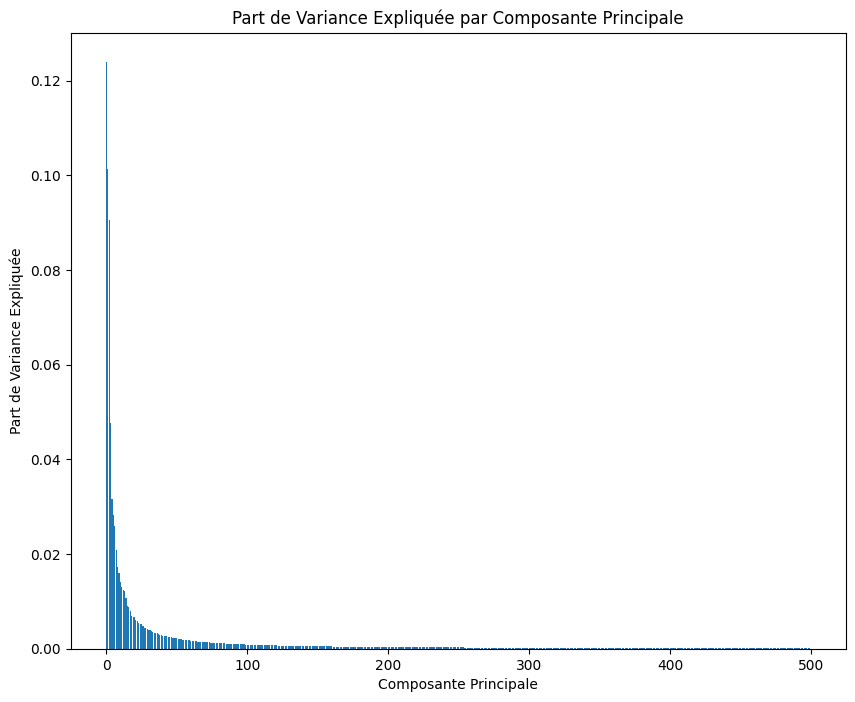

In [8]:
plt.figure(figsize=(10,8))
plt.bar(np.arange(ipca.n_components_), ipca.explained_variance_ratio_)
#plt.xticks([0, 1], ['Axe 1', 'Axe 2'])
plt.xlabel('Composante Principale')
plt.ylabel('Part de Variance Expliquée')
plt.title('Part de Variance Expliquée par Composante Principale')
plt.show()

In [11]:
# Calcul de variabilité représentée par nos 500 features
print("Variabilité concervée par les 500 features :", ipca.explained_variance_ratio_.sum())

Variabilité concervée par les 500 features : 0.8941408507860948


In [10]:
# Application du PCA à nos données
df_pca_transformed = ipca.transform(df_pca)
columns = [f"PCA_{i+1}" for i in range(ipca.n_components_)]
df_pca_transformed = pd.DataFrame(df_pca_transformed, columns=columns)

In [21]:
# enregistrement du dataframe des images PCA
df_pca_transformed.to_csv(r'..\..\data\processed\images_pca.csv', sep=',', encoding='utf-8', index=False, header=True) 

# Partie 4 : ML

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pycaret
from pycaret.classification import *

df = pd.read_csv(r'CSV\radios_stats.csv')

## Partie 4.1 : Pycaret sur données statistiques des images

In [11]:
X = df.drop('LABEL', axis=1)
y = df[['LABEL']]

label_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = label_encoder.fit_transform(y)
y_encode = pd.DataFrame(y_encoded, columns=label_encoder.categories_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

In [24]:
s = setup(df, target='LABEL', normalize=True, normalize_method='minmax')

,Description,Value
0,Session id,658
1,Target,LABEL
2,Target type,Multiclass
3,Target mapping,"COVID: 0, LUNG OPACITY: 1, NORMAL: 2, VIRAL PNEUMONIA: 3"
4,Original data shape,"(21165, 9)"
5,Transformed data shape,"(21165, 9)"
6,Transformed train set shape,"(14815, 9)"
7,Transformed test set shape,"(6350, 9)"
8,Numeric features,8
9,Preprocess,True


In [27]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6880,0.8605,0.6880,0.6734,0.6704,0.4987,0.5047,0.4310
rf,Random Forest Classifier,0.6769,0.8508,0.6769,0.6634,0.6614,0.4834,0.4878,0.2750
et,Extra Trees Classifier,0.6764,0.8496,0.6764,0.6626,0.6601,0.4805,0.4860,0.1100
gbc,Gradient Boosting Classifier,0.6695,0.0000,0.6695,0.6499,0.6386,0.4584,0.4696,1.7250
lda,Linear Discriminant Analysis,0.6503,0.0000,0.6503,0.6301,0.6152,0.4244,0.4362,0.0100
knn,K Neighbors Classifier,0.6444,0.8028,0.6444,0.6298,0.6309,0.4385,0.4407,0.2170
ridge,Ridge Classifier,0.6281,0.0000,0.6281,0.6381,0.5503,0.3665,0.3945,0.0110
lr,Logistic Regression,0.6279,0.0000,0.6279,0.5692,0.5601,0.3714,0.3944,0.2730
ada,Ada Boost Classifier,0.6200,0.0000,0.6200,0.5778,0.5788,0.3694,0.3821,0.1160
svm,SVM - Linear Kernel,0.6178,0.0000,0.6178,0.5160,0.5359,0.3518,0.3787,0.0180


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6808,0.8476,0.6808,0.6687,0.6645,0.4902,0.4942
1,0.6950,0.8525,0.6950,0.6890,0.6834,0.5151,0.5189
2,0.6869,0.8658,0.6869,0.6734,0.6703,0.4967,0.5025
3,0.6660,0.8440,0.6660,0.6478,0.6501,0.4677,0.4714
4,0.6626,0.8419,0.6626,0.6501,0.6459,0.4572,0.4631
5,0.6989,0.8574,0.6989,0.6893,0.6852,0.5208,0.5244
6,0.6509,0.8462,0.6509,0.6306,0.6331,0.4412,0.4454
7,0.6759,0.8505,0.6759,0.6635,0.6595,0.4807,0.4855
8,0.6745,0.8490,0.6745,0.6597,0.6605,0.4814,0.4852


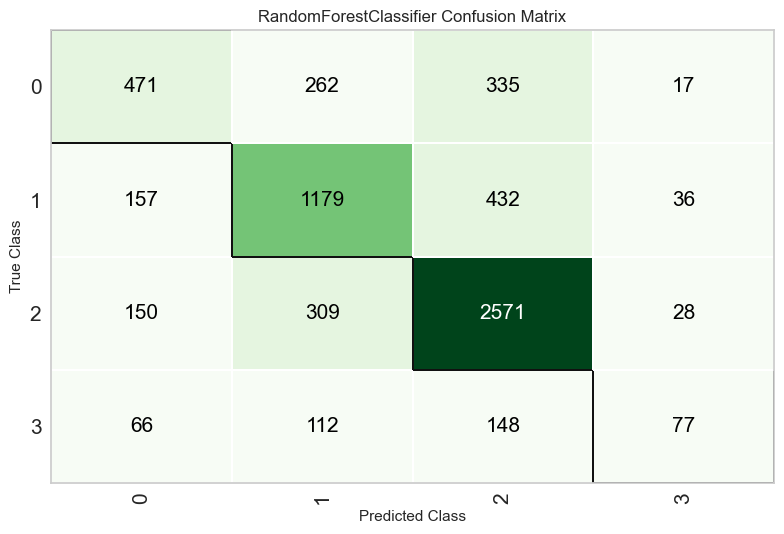

In [39]:
# Détail des performances sur un modèle de random forest
rf = create_model('rf')
plot_model(rf, plot='confusion_matrix')

## Partie 4.2 : Pycaret sur les images réduites en composantes principales (PCA)

### Partie 4.2.1 : Données non standardisées

In [2]:
metadatas = pd.read_csv('..\..\data\processed\metadatas_with_url.csv')
metadatas.head()

,FILE NAME,FORMAT,SIZE,URL,LABEL,IMG_URL,MASK_URL,MASK_RESIZED_URL,IMG_MASKED_URL
0,COVID-1,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-1.png,data\raw\COVID\masks\COVID-1.png,data\processed\COVID\masks\COVID-1.png,data\processed\COVID\images_masked\COVID-1.png
1,COVID-2,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-2.png,data\raw\COVID\masks\COVID-2.png,data\processed\COVID\masks\COVID-2.png,data\processed\COVID\images_masked\COVID-2.png
2,COVID-3,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-3.png,data\raw\COVID\masks\COVID-3.png,data\processed\COVID\masks\COVID-3.png,data\processed\COVID\images_masked\COVID-3.png
3,COVID-4,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-4.png,data\raw\COVID\masks\COVID-4.png,data\processed\COVID\masks\COVID-4.png,data\processed\COVID\images_masked\COVID-4.png
4,COVID-5,PNG,299*299,https://sirm.org/category/senza-categoria/covi...,COVID,data\raw\COVID\images\COVID-5.png,data\raw\COVID\masks\COVID-5.png,data\processed\COVID\masks\COVID-5.png,data\processed\COVID\images_masked\COVID-5.png


In [4]:
df = pd.read_csv(r"CSV\images_pca.csv")
df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_491,PCA_492,PCA_493,PCA_494,PCA_495,PCA_496,PCA_497,PCA_498,PCA_499,PCA_500
0,3583.851255,2715.792800,-2930.622862,-1902.871783,2509.364305,2591.233150,637.680547,2100.306843,-125.789815,-1635.977124,...,3.275762,-70.934091,-106.080904,-28.896038,87.616465,-153.449576,-102.142120,219.653290,-195.838154,-213.567562
1,-3800.307557,3521.576832,5116.674135,2324.623950,-881.781397,-1751.777994,455.090499,-1577.831306,165.346651,-3471.110214,...,-43.288676,-214.680869,-29.578901,102.038900,-20.559118,275.151662,158.666491,-193.050546,-49.004364,128.849430
2,2555.110875,-748.921228,-4599.536456,-65.393346,252.638013,-1266.105999,-1491.144974,1520.665307,814.593954,-2555.009354,...,256.171827,-95.301097,59.789952,-25.924559,91.886860,-166.995669,108.966964,0.297694,-5.326451,58.926651
3,1239.354481,4649.946118,-3039.659681,842.490184,-1599.908977,433.240174,-3915.753484,-1489.312728,-342.235045,-1015.023604,...,164.315258,-60.847760,-84.768668,56.944302,78.257800,59.511469,-194.670697,88.085263,-103.634720,191.034753
4,-1919.280188,7229.741998,4566.923942,3049.264918,-978.448052,-1418.679733,2504.599185,-2735.640384,-834.759433,-3435.678797,...,-79.705978,175.194267,135.027692,-91.340959,-141.140620,-210.413008,-13.800346,-37.497001,-102.113699,-173.322992


<Axes: >

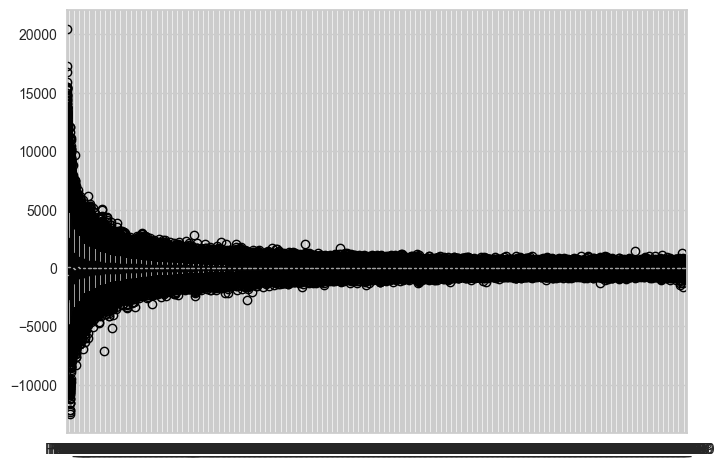

In [6]:
# Affichage des distributions de chaque features
df.boxplot()

Il semble y avoir des différence d'échelle, mais en même temps nous avons vu que les premières colonnes étaient celles qui représentaient le plus de variabilité des pixels d'origine, donc on peut essayer dans un premier temps de laisser cette différence d'échelle.

In [7]:
df['label'] = metadatas['LABEL']

In [ ]:
s = setup(df, target='label', session_id=42)

,Description,Value
0,Session id,4056
1,Target,label
2,Target type,Multiclass
3,Target mapping,"COVID: 0, LUNG OPACITY: 1, NORMAL: 2, VIRAL PNEUMONIA: 3"
4,Original data shape,"(21165, 501)"
5,Transformed data shape,"(21165, 501)"
6,Transformed train set shape,"(14815, 501)"
7,Transformed test set shape,"(6350, 501)"
8,Numeric features,500
9,Preprocess,True


In [10]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7073,0.8665,0.7073,0.7020,0.6910,0.5295,0.5382,3.6760
gbc,Gradient Boosting Classifier,0.6707,0.0000,0.6707,0.6621,0.6462,0.4637,0.4767,113.1980
knn,K Neighbors Classifier,0.6651,0.8086,0.6651,0.6557,0.6510,0.4608,0.4690,0.7110
qda,Quadratic Discriminant Analysis,0.6508,0.0000,0.6508,0.6476,0.6420,0.4473,0.4496,0.3960
lda,Linear Discriminant Analysis,0.6472,0.0000,0.6472,0.6277,0.6264,0.4321,0.4410,0.2420
ridge,Ridge Classifier,0.6468,0.0000,0.6468,0.6345,0.6167,0.4181,0.4346,0.1390
lr,Logistic Regression,0.6443,0.0000,0.6443,0.6233,0.6230,0.4320,0.4399,3.3590
rf,Random Forest Classifier,0.6348,0.8124,0.6348,0.6596,0.5951,0.3834,0.4064,3.6460
et,Extra Trees Classifier,0.5943,0.7967,0.5943,0.6469,0.5351,0.2896,0.3303,0.9830
ada,Ada Boost Classifier,0.5680,0.0000,0.5680,0.5427,0.5423,0.3031,0.3105,5.5590


Nous avons des taux légèrement meilleurs qu'avec les statistiques, mais vraiment pas assez bons. Nous allons essayer de normaliser les données pour voir s'il y a une amélioration

### Partie 4.2.2 : données standardisées

In [13]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
standardized_df = scaler.fit_transform(df.drop('label', axis=1))
standardized_df = pd.DataFrame(standardized_df, columns=df.columns[:-1])
standardized_df['label'] = df['label']

In [16]:
s = setup(standardized_df, target='label', session_id=42)
best = compare_models()

,Description,Value
0,Session id,1147
1,Target,label
2,Target type,Multiclass
3,Target mapping,"COVID: 0, LUNG OPACITY: 1, NORMAL: 2, VIRAL PNEUMONIA: 3"
4,Original data shape,"(21165, 501)"
5,Transformed data shape,"(21165, 501)"
6,Transformed train set shape,"(14815, 501)"
7,Transformed test set shape,"(6350, 501)"
8,Numeric features,500
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7043,0.8634,0.7043,0.6990,0.6873,0.5234,0.5329,5.5210
gbc,Gradient Boosting Classifier,0.6690,0.0000,0.6690,0.6615,0.6455,0.4603,0.4737,158.5930
lda,Linear Discriminant Analysis,0.6517,0.0000,0.6517,0.6337,0.6301,0.4379,0.4479,0.3610
lr,Logistic Regression,0.6510,0.0000,0.6510,0.6302,0.6295,0.4410,0.4491,0.5580
ridge,Ridge Classifier,0.6499,0.0000,0.6499,0.6383,0.6193,0.4228,0.4400,0.1600
qda,Quadratic Discriminant Analysis,0.6492,0.0000,0.6492,0.6451,0.6391,0.4438,0.4465,0.5720
rf,Random Forest Classifier,0.6325,0.8074,0.6325,0.6632,0.5910,0.3775,0.4020,5.8190
svm,SVM - Linear Kernel,0.6194,0.0000,0.6194,0.6010,0.6049,0.3963,0.4001,1.0040
et,Extra Trees Classifier,0.5899,0.7949,0.5899,0.6435,0.5278,0.2795,0.3218,1.4080
ada,Ada Boost Classifier,0.5658,0.0000,0.5658,0.5454,0.5429,0.3036,0.3098,7.6490


## Partie 4.3 : Sur les données PCA + les données statistiques

In [17]:
df_PCA = pd.read_csv(r"CSV\images_pca.csv")
df_stats = df = pd.read_csv(r'CSV\radios_stats.csv')

In [21]:
df = pd.concat([df_PCA, df_stats], axis=1)
df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_500,LABEL,mean_density,std,skewness,kurtosis,glcm_contrast,glcm_homogeneity,glcm_energy,glcm_entropy
0,3583.851255,2715.792800,-2930.622862,-1902.871783,2509.364305,2591.233150,637.680547,2100.306843,-125.789815,-1635.977124,...,-213.567562,COVID,126.684009,28.043102,1.452526,0.364808,201.225584,0.837578,0.761153,2.279505
1,-3800.307557,3521.576832,5116.674135,2324.623950,-881.781397,-1751.777994,455.090499,-1577.831306,165.346651,-3471.110214,...,128.849430,COVID,104.494054,30.292166,1.569322,1.204326,217.192566,0.819108,0.747576,2.410048
2,2555.110875,-748.921228,-4599.536456,-65.393346,252.638013,-1266.105999,-1491.144974,1520.665307,814.593954,-2555.009354,...,58.926651,COVID,101.497864,30.645126,1.410788,0.407165,177.269870,0.805559,0.730029,2.619181
3,1239.354481,4649.946118,-3039.659681,842.490184,-1599.908977,433.240174,-3915.753484,-1489.312728,-342.235045,-1015.023604,...,191.034753,COVID,98.898259,33.772493,1.348282,0.535025,246.648538,0.754334,0.691386,3.096489
4,-1919.280188,7229.741998,4566.923942,3049.264918,-978.448052,-1418.679733,2504.599185,-2735.640384,-834.759433,-3435.678797,...,-173.322992,COVID,124.493169,49.172014,1.785419,2.023710,283.338017,0.812399,0.747626,2.545051


In [24]:
s = setup(df, target='LABEL', normalize=True, normalize_method='minmax', train_size=0.8, session_id=42)
best = compare_models()

,Description,Value
0,Session id,42
1,Target,LABEL
2,Target type,Multiclass
3,Target mapping,"COVID: 0, LUNG OPACITY: 1, NORMAL: 2, VIRAL PNEUMONIA: 3"
4,Original data shape,"(21165, 509)"
5,Transformed data shape,"(21165, 509)"
6,Transformed train set shape,"(16932, 509)"
7,Transformed test set shape,"(4233, 509)"
8,Numeric features,508
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7573,0.9065,0.7573,0.7554,0.7508,0.6173,0.6209,7.4880
lda,Linear Discriminant Analysis,0.7283,0.0000,0.7283,0.7197,0.7188,0.5718,0.5756,0.4480
gbc,Gradient Boosting Classifier,0.7265,0.0000,0.7265,0.7237,0.7131,0.5628,0.5701,183.9470
ridge,Ridge Classifier,0.7118,0.0000,0.7118,0.7052,0.6865,0.5315,0.5449,0.1850
lr,Logistic Regression,0.7074,0.0000,0.7074,0.6922,0.6906,0.5337,0.5402,2.2800
svm,SVM - Linear Kernel,0.6909,0.0000,0.6909,0.6889,0.6744,0.5109,0.5202,0.6480
rf,Random Forest Classifier,0.6700,0.8571,0.6700,0.6958,0.6389,0.4519,0.4700,6.2230
qda,Quadratic Discriminant Analysis,0.6618,0.0000,0.6618,0.6563,0.6555,0.4692,0.4708,0.6340
et,Extra Trees Classifier,0.6364,0.8429,0.6364,0.6859,0.5839,0.3750,0.4081,1.6730
ada,Ada Boost Classifier,0.6185,0.0000,0.6185,0.5996,0.6006,0.3937,0.3987,8.5120


LightGBM semble être le meilleur modèle sur ces données. Nous allons dans la suite essayer HistGradientBoostingClassifier de sklearn qui en est inspiré